# Intro

## D-Linear usecase

In [10]:
from darts.datasets import WeatherDataset
from darts.models import DLinearModel
series = WeatherDataset().load()
# predicting atmospheric pressure
target = series['p (mbar)'][:100]
# optionally, use past observed rainfall (pretending to be unknown beyond index 100)
past_cov = series['rain (mm)'][:100]
# optionally, use future temperatures (pretending this component is a forecast)
future_cov = series['T (degC)'][:106]
# predict 6 pressure values using the 12 past values of pressure and rainfall, as well as the 6 temperature
# values corresponding to the forecasted period
model = DLinearModel(
    input_chunk_length=6,
    output_chunk_length=6,
    n_epochs=20,
)
model.fit(target, past_covariates=past_cov, future_covariates=future_cov)
pred = model.predict(6)
pred.values()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 114    | train
7 | linear_trend    | Linear           | 114    | train
8 | linear_fut_cov  | Linear           | 2      | train
-------------------------------------------------------------
230       Trainable params
0         Non-trainable params
230       Total params
0.001     Total estimated model params size (MB)
11        Modules in train 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

array([[668.47514761],
       [667.90421319],
       [667.78068018],
       [667.3076341 ],
       [666.82118674],
       [666.78018525]])

# Synthetic Data

## Simple Wave

In [11]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

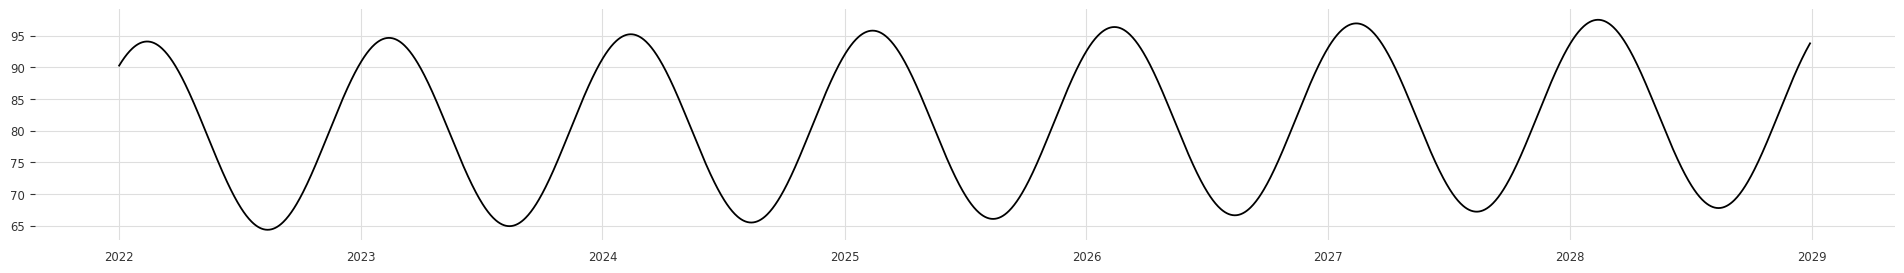

In [12]:
n_years = np.random.randint(1, 15)
frequency = 2 * np.pi / 365.25
beta = 1
amplitude = np.random.randint(-100, 100)
elevation_power = 0
amplitude_change_power = 0
phase_shift = np.random.randint(-180, 180)
period_starts = pd.Timestamp('2022-01-01')
a = np.random.randint(-5, 5) / (n_years * 365.25)
b = np.random.randint(-100, 100)

duration_days = 365 * n_years
period_ends = period_starts + pd.Timedelta(days=duration_days)

x = np.linspace(1, duration_days, duration_days)#*24)
y = amplitude * np.sin(frequency * x + phase_shift)
# y = amplitude*(x**amplitude_change_power)*np.sin(x**beta*frequency)
y += a * x + b
y += -1 + x**elevation_power
x_date = pd.date_range(period_starts, period_ends, freq='D')[:-1]

plt.figure(figsize=(24,3))
plt.plot(x_date, y)
plt.show()

### D-Linear

In [13]:
from darts import TimeSeries
from sklearn.metrics import mean_squared_error
data = pd.DataFrame({'date': x_date, 'y': y})
series = TimeSeries.from_dataframe(data, time_col='date', value_cols='y')

train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

model = DLinearModel(
    input_chunk_length=6,
    output_chunk_length=6,
    n_epochs=20,
)

model.fit(train)

pred = model.predict(len(test))
pred_values = pred.values()

mse = mean_squared_error(test.values(), pred_values)
print(f'Mean Squared Error: {mse}')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 42     | train
7 | linear_trend    | Linear           | 42     | train
-------------------------------------------------------------
84        Trainable params
0         Non-trainable params
84        Total params
0.000     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Mean Squared Error: 3111.6742743246273


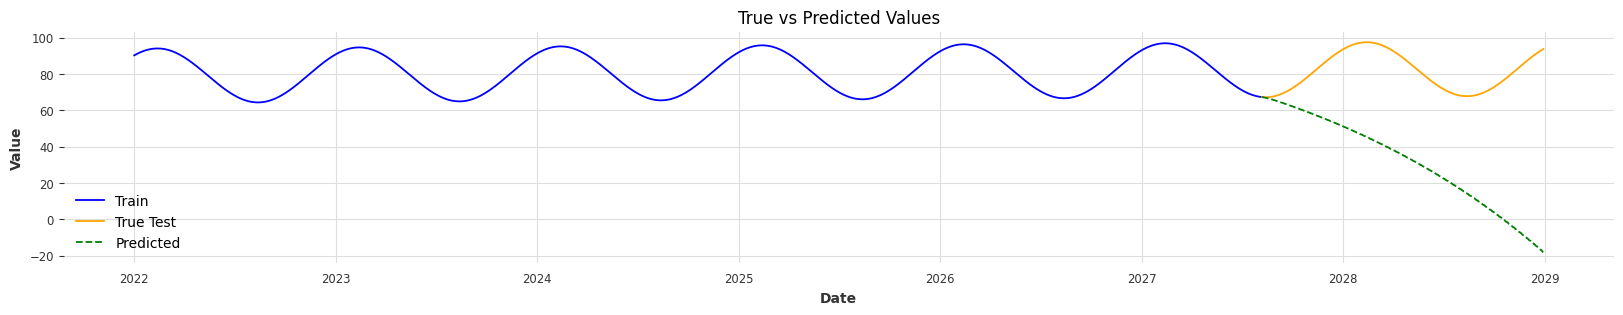

In [14]:
train_values = train.values()
test_values = test.values()
pred_values = pred.values()


pred_index = test.time_index
plt.figure(figsize=(20, 3))
plt.plot(train.time_index, train_values, label='Train', color='blue')
plt.plot(test.time_index, test_values, label='True Test', color='orange')
plt.plot(pred_index, pred_values, label='Predicted', color='green', linestyle='--')

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


### SineNN

In [15]:
from sklearn.model_selection import train_test_split
from sinenn.metrics import amape_score
from sinenn.sinenn import build_multiwave_model
import tensorflow as tf
X_train, X_test, y_train, y_test = train_test_split(x.reshape(-1,1), y, shuffle=False)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 1)         │       0 │ -                    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Wave_1 (Functional) │ (None, 1)         │       9 │ input[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Wave_0.5            │ (None, 1)         │       9 │ input[0][0]          │
│ (Functional)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Wave_0.333          │ (None, 1)         │       9 │ input[0][0]          │
│ (Functional)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ output (Add)        │ (None, 1)         │       0 │ Wave_1[0][0],        │
│                     │                   │         │ Wave_0.5[0][0],      │
│                     │                   │         │ Wave_0.333[0][0]     │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 27 (108.00 B)

 Trainable params: 21 (84.00 B)

 Non-trainable params: 6 (24.00 B)

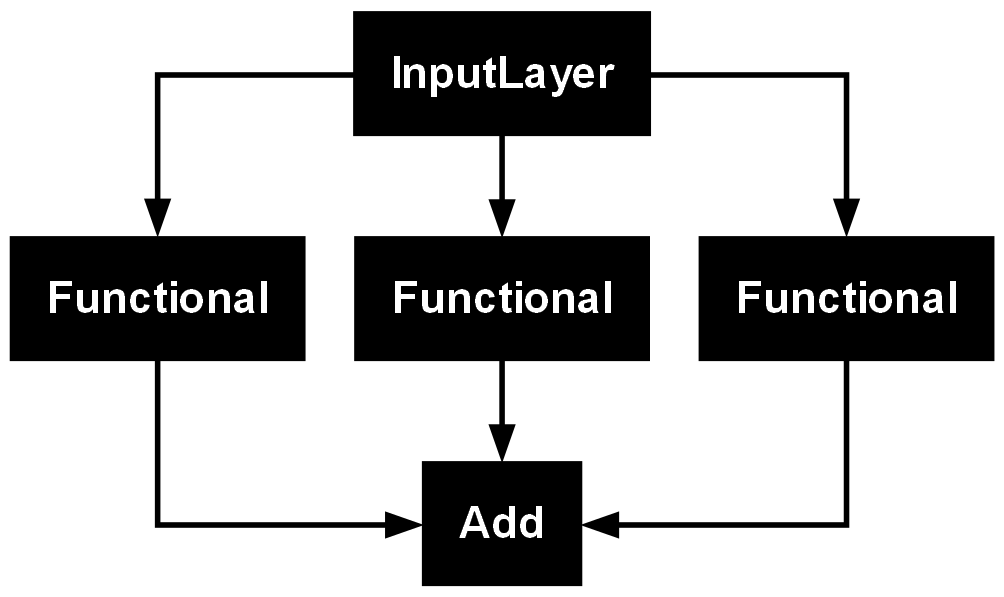

In [16]:
multiwave_model = build_multiwave_model(X_train, y_train, waves=[1, 1/2, 1/3], learning_rate=0.1)
tf.keras.utils.plot_model(multiwave_model)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


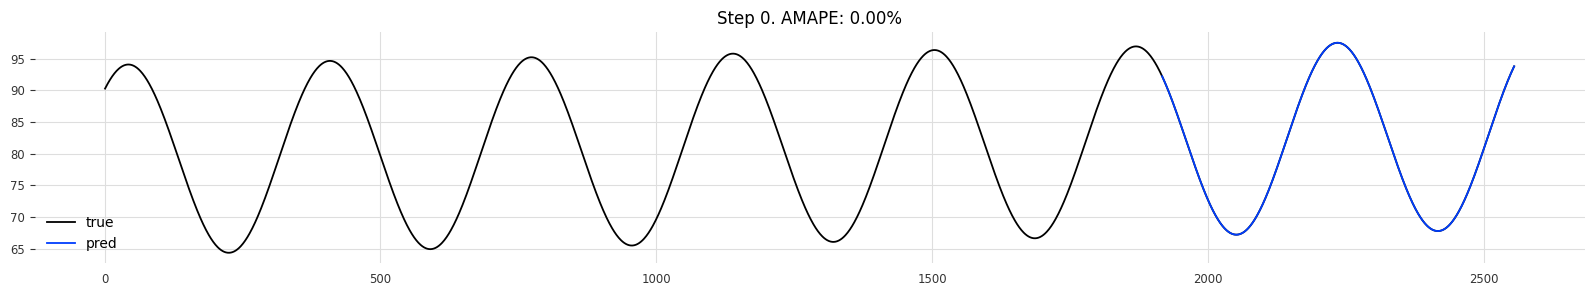

In [17]:
for step in range(1):
    multiwave_model.fit(
        X_train,
        y_train,
        epochs=50,
        verbose=False
        )
    y_pred = multiwave_model.predict(X_test)
    amape = amape_score(y_test, y_pred, reference=y_train)
    fig = plt.figure(figsize=(20,3))
    plt.plot(x.flatten(), y, label='true')
    plt.plot(X_test.flatten(), y_pred, label='pred')
    plt.title(f'Step {step}. AMAPE: {amape:.2f}%')
    plt.legend()
    plt.show()

## Broken Multiwave

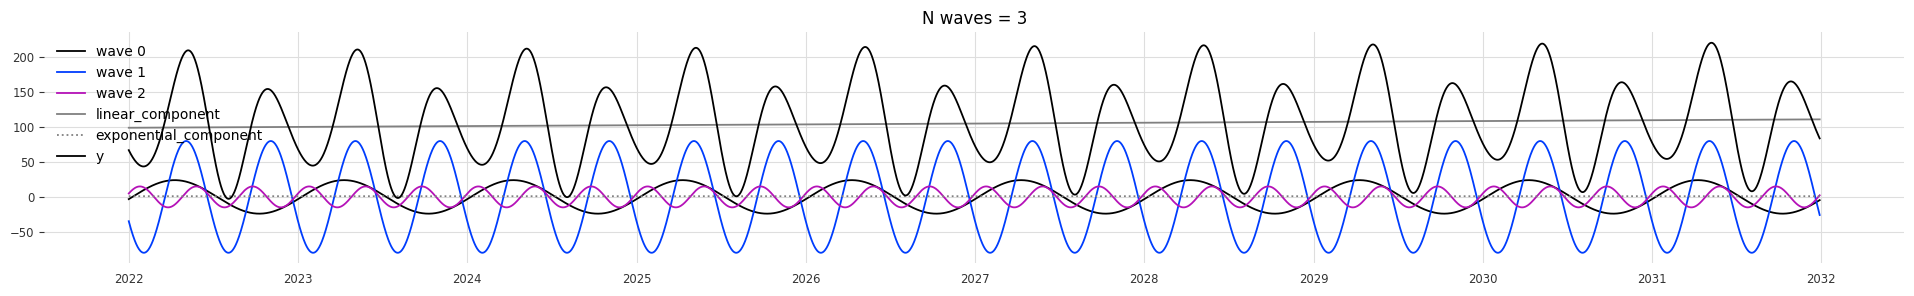

In [18]:
plt.figure(figsize=(24, 3))
n_years = np.random.randint(1, 15)
period_starts = pd.Timestamp('2022-01-01')
duration_days = 365 * n_years
period_ends = period_starts + pd.Timedelta(days=duration_days)
x_date = pd.date_range(period_starts, period_ends, freq='D')[:-1]


N = 3
X = np.linspace(1, duration_days, duration_days)
a = np.random.randint(-500, 500) / (n_years * 365.25)

waves = {}
for i in range(N):
    frequency = 2 * np.pi / 365.25 * (i + 1)

    beta = 1
    elevation_power = 0
    amplitude_change_power = 0
    variation = True

    amplitude = np.random.randint(-100, 100)
    phase_shift = np.random.randint(-180, 180)
  
    
    b = np.random.randint(-100, 100)

    if not variation:
        waves[i] = amplitude * np.sin(frequency * X + phase_shift)
    else:
        waves[i] = amplitude * (X**amplitude_change_power) * np.sin(X**beta * frequency + phase_shift)

    plt.plot(x_date, waves[i], label=f'wave {i}')
y = np.sum(list(waves.values()), axis=0)
linear_component = a * X + b
exponential_component = X**elevation_power
y += linear_component
y += exponential_component
plt.plot(x_date, linear_component, color='grey', label='linear_component')
plt.plot(x_date, exponential_component, color='grey', label='exponential_component', linestyle='dotted')
plt.plot(x_date, y, color='black', label='y')
plt.legend()
plt.title(f'N waves = {N}')
plt.show()

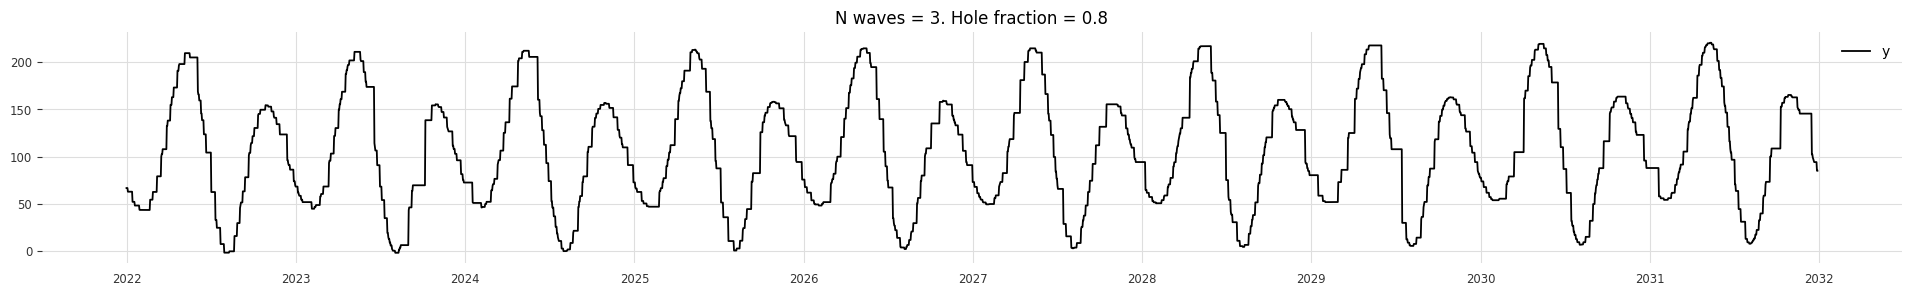

In [19]:
hole_fraction = 0.8
len_ = len(y)
n_holes = int(len_ * hole_fraction)
holes_idx = np.random.choice(len_, n_holes, replace=False)
y[holes_idx] = None
y = pd.Series(y).ffill().bfill().to_numpy()
plt.figure(figsize=(24, 3))
plt.plot(x_date, y, color='black', label='y')
plt.legend()
plt.title(f'N waves = {N}. Hole fraction = {hole_fraction}')
plt.show()

### D-Linear

In [20]:
data = pd.DataFrame({'date': x_date, 'y': y})
series = TimeSeries.from_dataframe(data, time_col='date', value_cols='y')

train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

model = DLinearModel(
    input_chunk_length=6,
    output_chunk_length=6,
    n_epochs=20,
)

model.fit(train)

pred = model.predict(len(test))
pred_values = pred.values()

mse = mean_squared_error(test.values(), pred_values)
print(f'Mean Squared Error: {mse}')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 42     | train
7 | linear_trend    | Linear           | 42     | train
-------------------------------------------------------------
84        Trainable params
0         Non-trainable params
84        Total params
0.000     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Mean Squared Error: 8836.777725256452


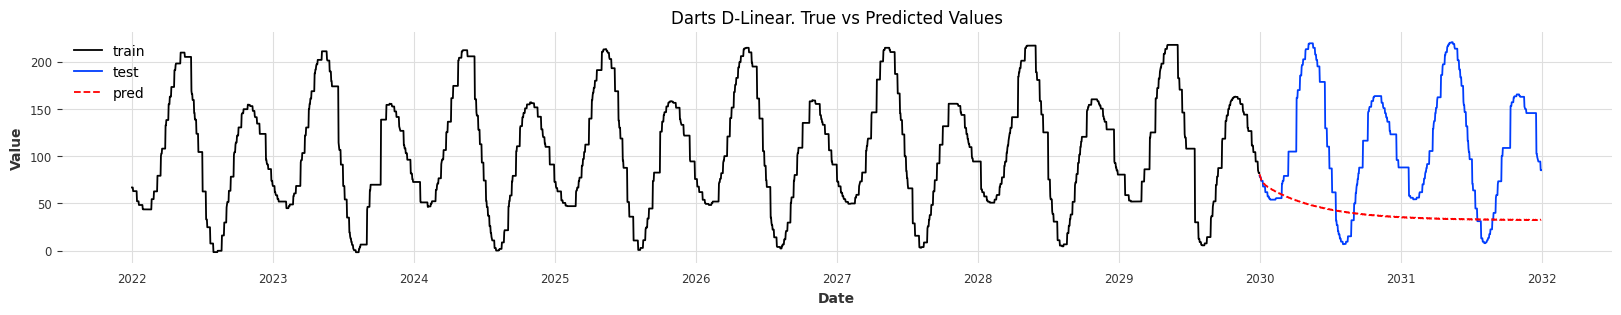

In [21]:
train_values = train.values()
test_values = test.values()
pred_values = pred.values()


pred_index = test.time_index
plt.figure(figsize=(20, 3))
plt.plot(train.time_index, train_values, label='train')
plt.plot(test.time_index, test_values, label='test')
plt.plot(pred_index, pred_values, label='pred', color='red', linestyle='--')

plt.title('Darts D-Linear. True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


In [22]:
amape_score(pred_values, test_values, reference=train_values)

52.24347968146942

### SineNN

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 1)         │       0 │ -                    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Wave_1 (Functional) │ (None, 1)         │       9 │ input[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Wave_0.5            │ (None, 1)         │       9 │ input[0][0]          │
│ (Functional)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Wave_0.333          │ (None, 1)         │       9 │ input[0][0]          │
│ (Functional)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ output (Add)        │ (None, 1)         │       0 │ Wave_1[0][0],        │
│                     │                   │         │ Wave_0.5[0][0],      │
│                     │                   │         │ Wave_0.333[0][0]     │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 27 (108.00 B)

 Trainable params: 21 (84.00 B)

 Non-trainable params: 6 (24.00 B)

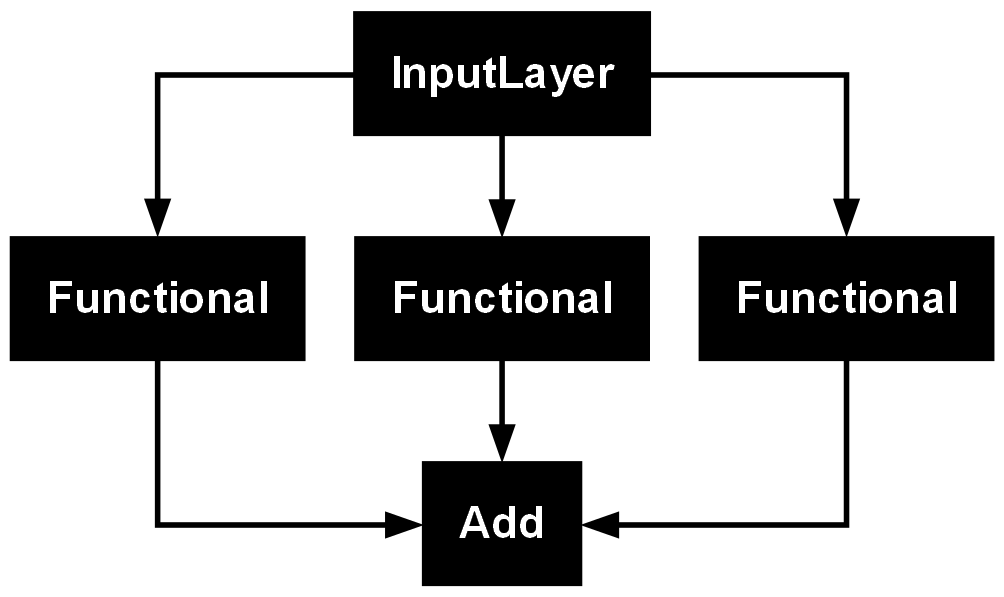

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1,1), y, shuffle=False)
multiwave_model = build_multiwave_model(
    X_train, y_train, waves=[1, 1/2, 1/3],
    learning_rate=0.1
)
tf.keras.utils.plot_model(multiwave_model)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


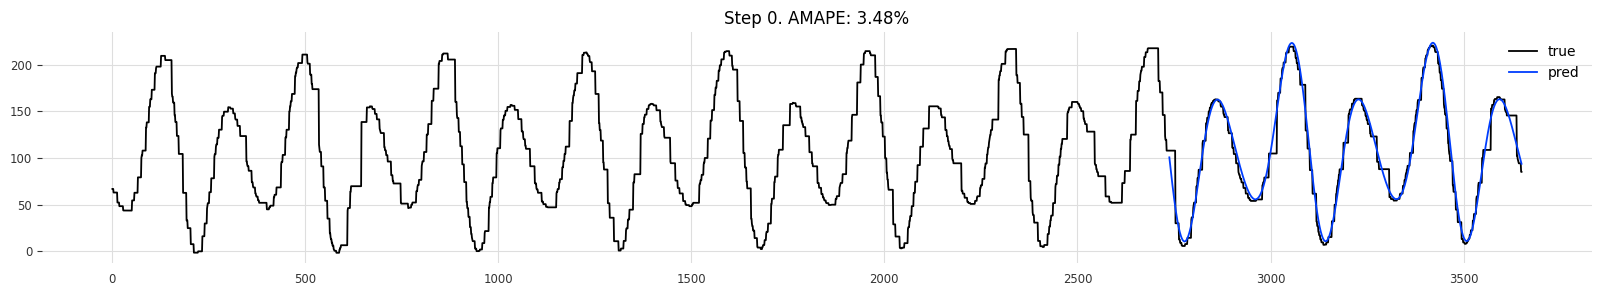

In [29]:
for step in range(1):
    multiwave_model.fit(
        X_train,
        y_train,
        epochs=50,
        verbose=False
        )
    y_pred = multiwave_model.predict(X_test)
    amape = amape_score(y_test, y_pred, reference=y_train)
    fig = plt.figure(figsize=(20,3))
    plt.plot(x.flatten(), y, label='true')
    plt.plot(X_test.flatten(), y_pred, label='pred')
    plt.title(f'Step {step}. AMAPE: {amape:.2f}%')
    plt.legend()
    plt.show()

## Noise Distortion

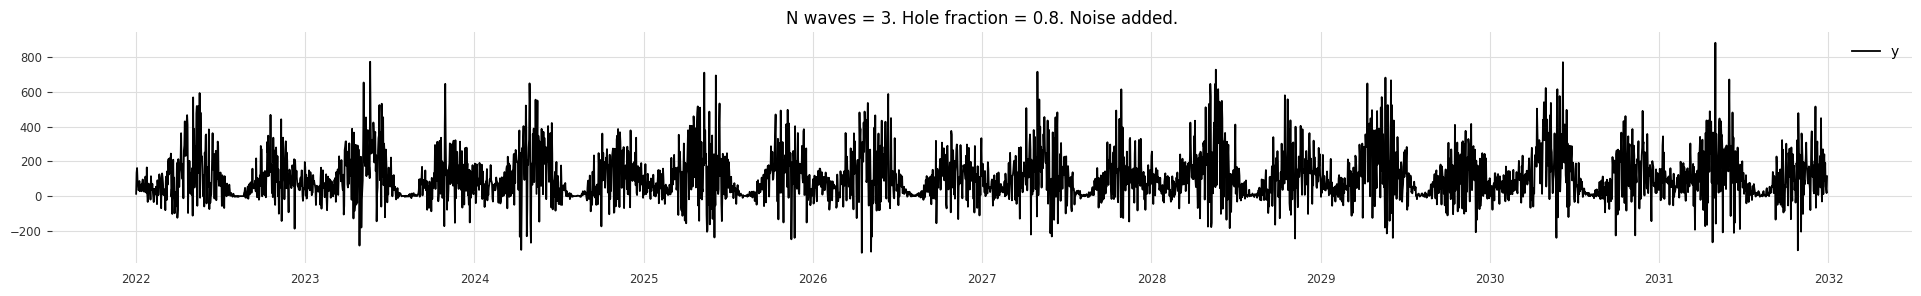

In [30]:
y *= (np.ones(len_) + np.random.randn(len_))
plt.figure(figsize=(24, 3))
plt.plot(x_date, y, color='black', label='y')
plt.legend()
plt.title(f'N waves = {N}. Hole fraction = {hole_fraction}. Noise added.')
plt.show()

### D-Linear

In [31]:
data = pd.DataFrame({'date': x_date, 'y': y})
series = TimeSeries.from_dataframe(data, time_col='date', value_cols='y')

train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

model = DLinearModel(
    input_chunk_length=6,
    output_chunk_length=6,
    n_epochs=20,
)

model.fit(train)

pred = model.predict(len(test))
pred_values = pred.values()

mse = mean_squared_error(test.values(), pred_values)
print(f'Mean Squared Error: {mse}')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 42     | train
7 | linear_trend    | Linear           | 42     | train
-------------------------------------------------------------
84        Trainable params
0         Non-trainable params
84        Total params
0.000     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Mean Squared Error: 30588.447636115423


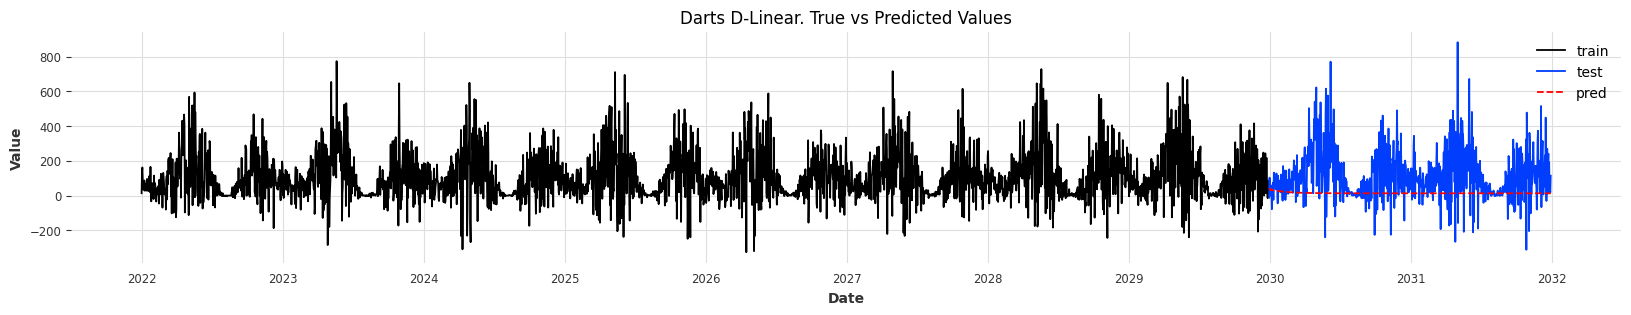

In [33]:
train_values = train.values()
test_values = test.values()
pred_values = pred.values()


pred_index = test.time_index
plt.figure(figsize=(20, 3))
plt.plot(train.time_index, train_values, label='train')
plt.plot(test.time_index, test_values, label='test')
plt.plot(pred_index, pred_values, label='pred', color='red', linestyle='--')

plt.title('Darts D-Linear. True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


In [34]:
amape_score(pred_values, test_values, reference=train_values)

16.23024511607715

### SineNN

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 1)         │       0 │ -                    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Wave_1 (Functional) │ (None, 1)         │       9 │ input[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Wave_0.5            │ (None, 1)         │       9 │ input[0][0]          │
│ (Functional)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Wave_0.333          │ (None, 1)         │       9 │ input[0][0]          │
│ (Functional)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ output (Add)        │ (None, 1)         │       0 │ Wave_1[0][0],        │
│                     │                   │         │ Wave_0.5[0][0],      │
│                     │                   │         │ Wave_0.333[0][0]     │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 27 (108.00 B)

 Trainable params: 21 (84.00 B)

 Non-trainable params: 6 (24.00 B)

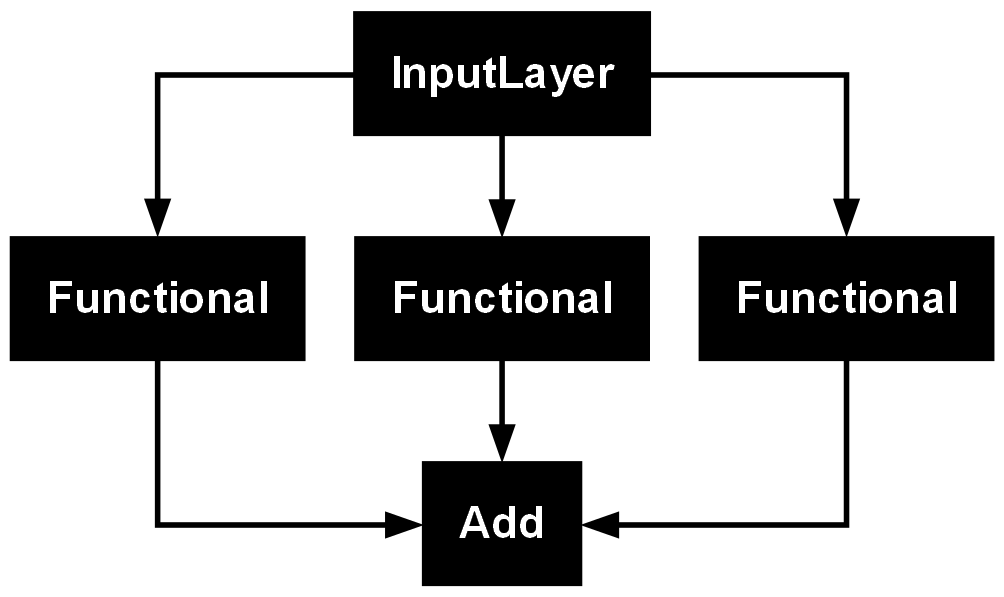

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1,1), y, shuffle=False)
multiwave_model = build_multiwave_model(
    X_train, y_train, waves=[1, 1/2, 1/3],
    learning_rate=0.1
)
tf.keras.utils.plot_model(multiwave_model)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


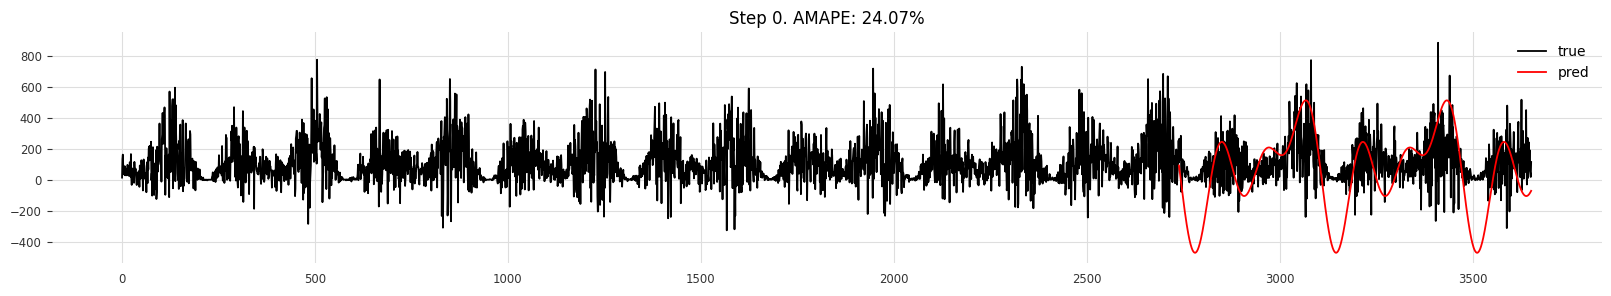

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


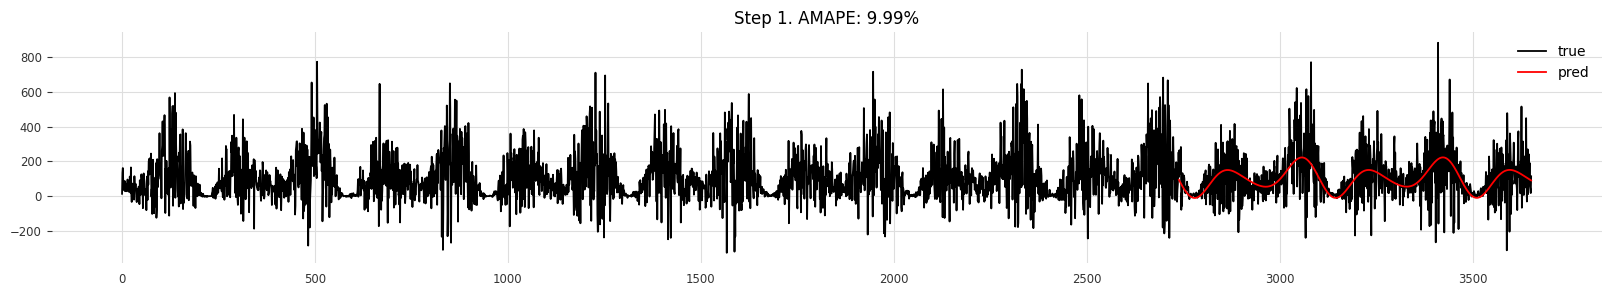

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


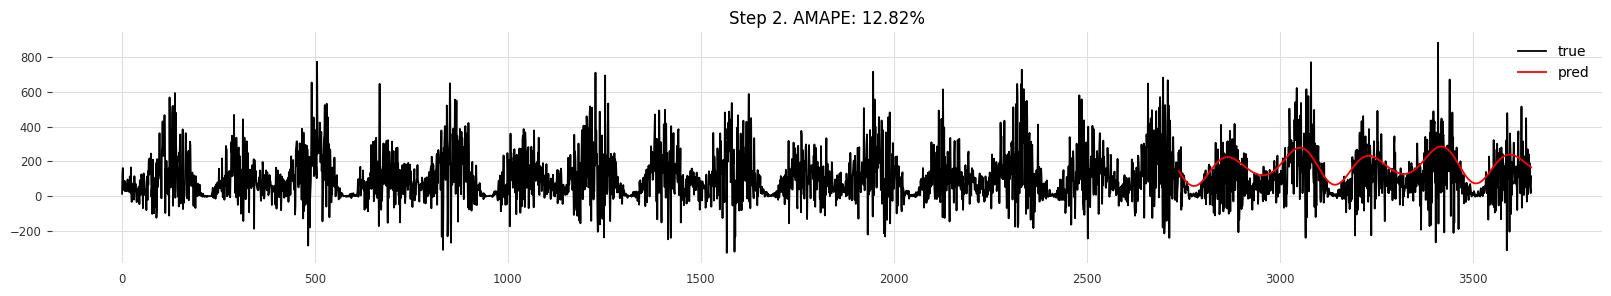

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step


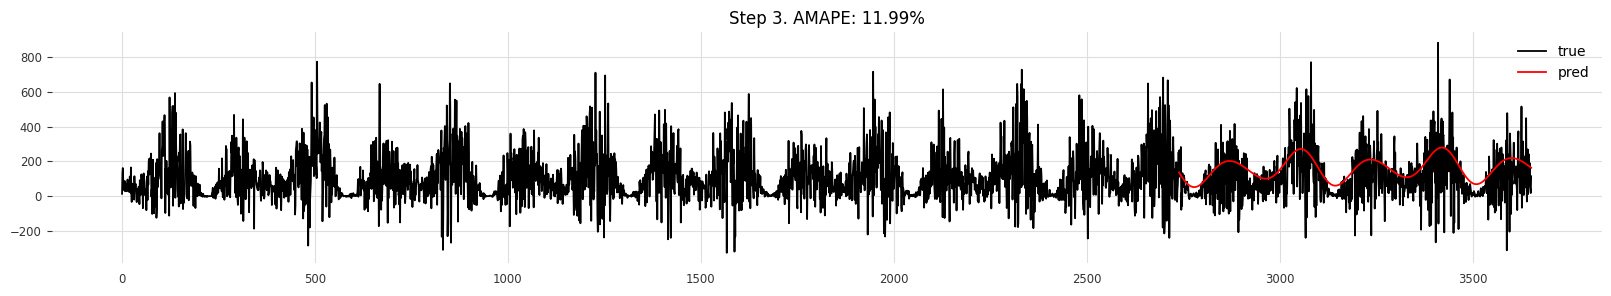

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


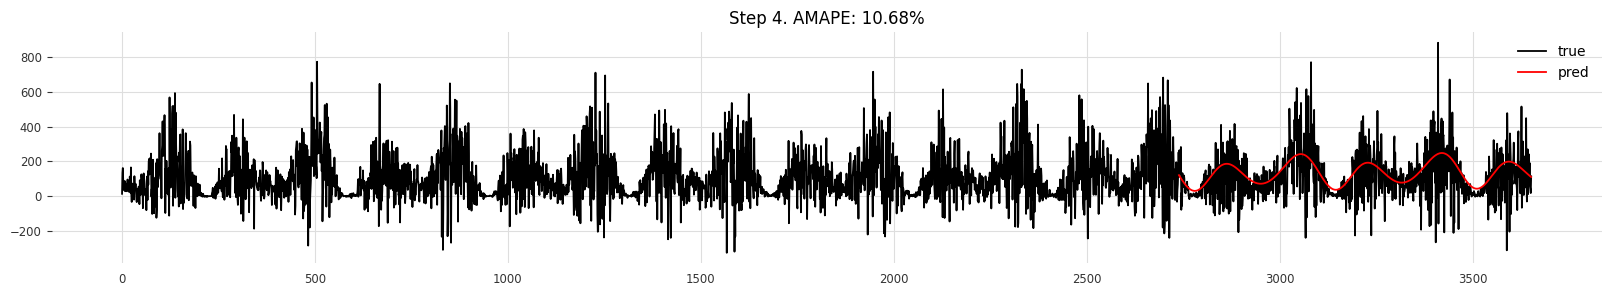

In [38]:
for step in range(5):
    multiwave_model.fit(
        X_train,
        y_train,
        epochs=50,
        verbose=False
        )
    y_pred = multiwave_model.predict(X_test)
    amape = amape_score(y_test, y_pred, reference=y_train)
    fig = plt.figure(figsize=(20, 3))
    plt.plot(x.flatten(), y, label='true')
    plt.plot(X_test.flatten(), y_pred, color='red', label='pred')
    plt.title(f'Step {step}. AMAPE: {amape:.2f}%')
    plt.legend()
    plt.show()